In [15]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format='retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
#export
from exp.nb_06 import *

# ConvNet

In [17]:
x_train, y_train, x_valid, y_valid = get_data()

x_train, x_valid = normalize_to(x_train, x_valid)
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)

nh, bs = 50, 512
c = y_train.max().item() + 1
loss_func = F.cross_entropy

data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [18]:
mnist_view = view_tfm(1, 28, 28)
cbfs = [Recorder,
       partial(AvgStatsCallback, accuracy),
       CudaCallback,
       partial(BatchTransformXCallback, mnist_view)]

In [19]:
nfs = [8, 16, 32, 64, 64]

In [20]:
learn, run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs)

In [21]:
%time run.fit(2, learn)

train: [1.23830921875, tensor(0.5881, device='cuda:0')]
valid: [0.2225708251953125, tensor(0.9323, device='cuda:0')]
train: [0.18039552734375, tensor(0.9454, device='cuda:0')]
valid: [0.11884620361328126, tensor(0.9638, device='cuda:0')]
CPU times: user 3.68 s, sys: 800 ms, total: 4.48 s
Wall time: 4.08 s


# Batchnorm

Building our own `BatchNorm` layer

In [22]:
class BatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        self.mom, self.eps = mom, eps
        self.mults = nn.Parameter(torch.ones(nf, 1, 1))
        self.adds = nn.Parameter(torch.zeros(nf, 1, 1))
        self.register_buffer('vars', torch.ones(1, nf, 1, 1))
        self.register_buffer('means', torch.zeros(1, nf, 1, 1))
        
    def update_stats(self, x):
        m = x.mean((0, 2, 3), keepdim=True)
        v = x.var((0, 2, 3), keepdim=True)
        self.means.lerp_(m, self.mom) #lerp is linear interpolation
        self.vars.lerp_(v, self.mom)
        return m,v
        
    def forward(self, x):
        if self.training:
            with torch.no_grad():
                m, v = self.update_stats(x)
        else:
            m, v = self.means, self.vars
        x = (x-m) / (v+self.eps).sqrt()
        return x*self.mults + self.adds

In [23]:
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    # No bias needed if using bn
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
             GeneralRelu(**kwargs)]
    if bn:
        layers.append(BatchNorm(nf))
    return nn.Sequential(*layers)

In [24]:
#export
def init_cnn_(m, f):
    if isinstance(m, nn.Conv2d):
        f(m.weight, a=0.1)
        if getattr(m, 'bias', None) is not None:
            m.bias.data.zero_()
    for l in m.children():
        init_cnn_(l, f)
        
def init_cnn(m, uniform=False):
    f = init.kaiming_uniform_ if uniform else init.kaiming_normal_
    init_cnn_(m, f)
    
def get_learn_run(nfs, data, lr, layer, cbs=None, opt_func=None, uniform=False, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model, uniform=uniform)
    return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

In [25]:
learn, run = get_learn_run(nfs, data, 1., conv_layer, cbs=cbfs)

train: [0.262470390625, tensor(0.9174, device='cuda:0')]
valid: [0.3876377197265625, tensor(0.9027, device='cuda:0')]


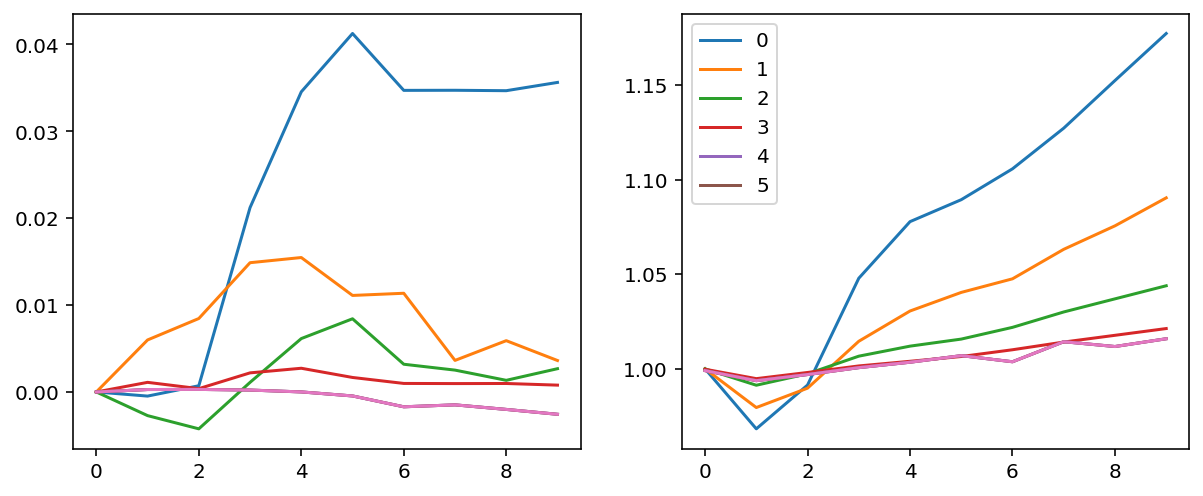

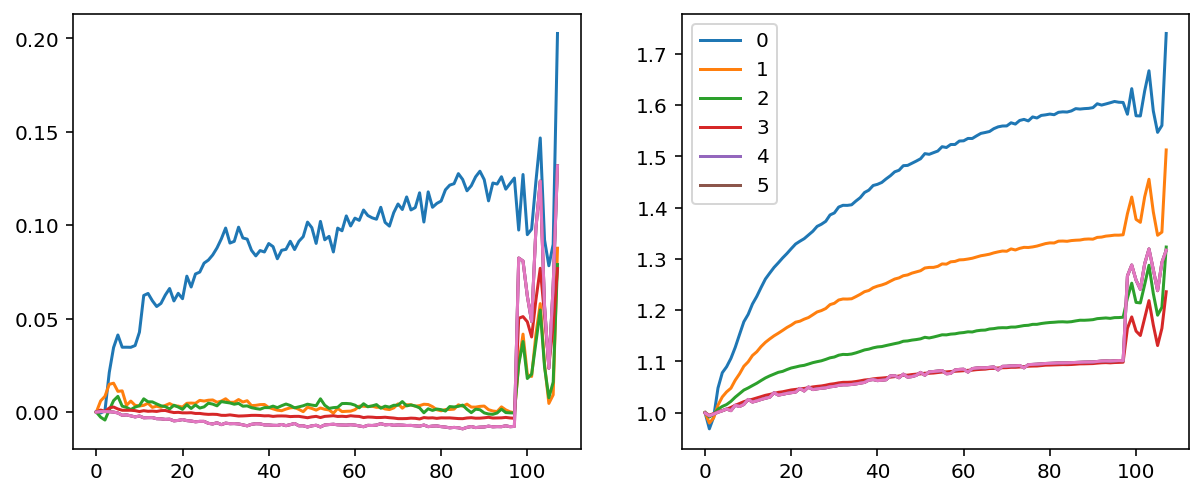

In [26]:
with Hooks(learn.model, append_stats) as hooks:
    run.fit(1, learn)
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10,4))
    for h in hooks[:-1]:
        ms, ss = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
        h.remove()
    plt.legend(range(6));
    
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10,4))
    for h in hooks[:-1]:
        ms, ss = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
    plt.legend(range(6));

In [27]:
learn, run = get_learn_run(nfs, data, 1.0, conv_layer, cbs=cbfs)

In [28]:
%time run.fit(3, learn)

train: [0.27263150390625, tensor(0.9161, device='cuda:0')]
valid: [0.13010936279296875, tensor(0.9621, device='cuda:0')]
train: [0.094423564453125, tensor(0.9711, device='cuda:0')]
valid: [0.086861083984375, tensor(0.9740, device='cuda:0')]
train: [0.0710674853515625, tensor(0.9775, device='cuda:0')]
valid: [0.08651410522460938, tensor(0.9739, device='cuda:0')]
CPU times: user 5.58 s, sys: 1.12 s, total: 6.71 s
Wall time: 6.11 s


## Builtin batchnorm

In [29]:
#export
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
             GeneralRelu(**kwargs)]
    if bn:
        layers.append(nn.BatchNorm2d(nf, eps=1e-5, momentum=0.1))
    return nn.Sequential(*layers)

In [30]:
learn, run = get_learn_run(nfs, data, 1., conv_layer, cbs=cbfs)

In [31]:
%time run.fit(3, learn)

train: [0.2363941015625, tensor(0.9266, device='cuda:0')]
valid: [0.1182248046875, tensor(0.9633, device='cuda:0')]
train: [0.066611640625, tensor(0.9797, device='cuda:0')]
valid: [0.06637012939453125, tensor(0.9800, device='cuda:0')]
train: [0.0445119482421875, tensor(0.9861, device='cuda:0')]
valid: [0.06606260375976562, tensor(0.9798, device='cuda:0')]
CPU times: user 5.4 s, sys: 1.09 s, total: 6.5 s
Wall time: 5.91 s


## With scheduler

In [32]:
sched = combine_scheds([0.3, 0.7], [sched_lin(0.6, 2.), sched_lin(2.,  0.1)])

In [33]:
learn, run = get_learn_run(nfs, data, 0.9, conv_layer, cbs=cbfs
                          + [partial(ParamScheduler, 'lr', sched)])

In [34]:
run.fit(8, learn)

train: [0.2386287890625, tensor(0.9267, device='cuda:0')]
valid: [0.13989921875, tensor(0.9561, device='cuda:0')]
train: [0.0798491552734375, tensor(0.9746, device='cuda:0')]
valid: [0.11783636474609376, tensor(0.9651, device='cuda:0')]
train: [0.053558525390625, tensor(0.9830, device='cuda:0')]
valid: [0.06087708740234375, tensor(0.9812, device='cuda:0')]
train: [0.03307242431640625, tensor(0.9897, device='cuda:0')]
valid: [0.05184014892578125, tensor(0.9852, device='cuda:0')]
train: [0.018789073486328123, tensor(0.9943, device='cuda:0')]
valid: [0.04138990478515625, tensor(0.9882, device='cuda:0')]
train: [0.01071025390625, tensor(0.9971, device='cuda:0')]
valid: [0.04135297546386719, tensor(0.9881, device='cuda:0')]
train: [0.006045562744140625, tensor(0.9990, device='cuda:0')]
valid: [0.038408462524414065, tensor(0.9893, device='cuda:0')]
train: [0.004149520874023437, tensor(0.9994, device='cuda:0')]
valid: [0.03723149719238281, tensor(0.9893, device='cuda:0')]


### Layer norm

In [36]:
class LayerNorm(nn.Module):
    __constants__ = ['eps']
    def __init__(self, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.mult = nn.Parameter(tensor(1.))
        self.add = nn.Parameter(tensor(0.))
        
    def forward(self, x):
        m = x.mean((1,2,3), keepdim=True)
        v = x.std((1,2,3), keepdim=True)
        x = (x-m)/((v+self.eps).sqrt())
        return x*self.mult + self.add

In [37]:
def conv_ln(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=True),
             GeneralRelu(**kwargs)]
    if bn:
        layers.append(LayerNorm())
    return nn.Sequential(*layers)

In [38]:
learn, run = get_learn_run(nfs, data, 0.8, conv_ln, cbs=cbfs)

In [39]:
%time run.fit(3, learn)

train: [nan, tensor(0.1700, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
CPU times: user 6.63 s, sys: 1.22 s, total: 7.85 s
Wall time: 7.24 s


## Instance norm

In [40]:
class InstanceNorm(nn.Module):
    __constants__ = ['eps']
    def __init__(self, nf, eps=1e-0):
        super().__init__()
        self.eps = eps
        self.mults = nn.Parameter(torch.ones(nf, 1, 1))
        self.adds = nn.Parameter(torch.zeros(nf, 1, 1))
        
    def forward(self, x):
        m = x.mean((2,3), keepdim=True)
        v = x.std((2,3), keepdim=True)
        res = (x-m) / ((v+self.eps).sqrt())
        return res * self.mults + self.adds

In [41]:
def conv_in(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=True),
             GeneralRelu(**kwargs)]
    if bn:
        layers.append(InstanceNorm(nf))
    return nn.Sequential(*layers)

In [42]:
learn, run = get_learn_run(nfs, data, 0.1, conv_in, cbs=cbfs)

In [43]:
%time run.fit(3, learn)

train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
CPU times: user 6.77 s, sys: 1.24 s, total: 8 s
Wall time: 7.4 s


## Fix small batch sizes

In [49]:
data = DataBunch(*get_dls(train_ds, valid_ds, 2), c)

In [50]:
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
             GeneralRelu(**kwargs)]
    if bn:
        layers.append(nn.BatchNorm2d(nf, eps=1e-5, momentum=0.1))
    return nn.Sequential(*layers)

In [51]:
learn, run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs)

In [47]:
%time run.fit(1, learn)

train: [2.33496203125, tensor(0.1837, device='cuda:0')]
valid: [3.71847265625, tensor(0.1708, device='cuda:0')]
CPU times: user 1min 34s, sys: 956 ms, total: 1min 35s
Wall time: 1min 35s


In [48]:
# can try to increase epsilon to 1e-2 here - maybe that helps because division will be
# more controlled

In [52]:
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
             GeneralRelu(**kwargs)]
    if bn:
        layers.append(nn.BatchNorm2d(nf, eps=1e-2, momentum=0.1))
    return nn.Sequential(*layers)

In [53]:
learn, run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs)

In [54]:
%time run.fit(1, learn)

train: [2.30141875, tensor(0.1912, device='cuda:0')]
valid: [12.18521640625, tensor(0.3145, device='cuda:0')]
CPU times: user 1min 35s, sys: 764 ms, total: 1min 36s
Wall time: 1min 35s


# Running Batch Norm

In [55]:
class RunningBatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        self.mom, self.eps = mom, eps
        self.mults = nn.Parameter(torch.ones(nf, 1, 1))
        self.adds = nn.Parameter(torch.zeros(nf, 1, 1))
        self.register_buffer('sums', torch.zeros(1, nf, 1, 1))
        self.register_buffer('sqrs', torch.zeros(1, nf, 1, 1))
        self.register_buffer('batch', tensor(0.))
        self.register_buffer('count', tensor(0.))
        self.register_buffer('step', tensor(0.))
        self.register_buffer('dbias', tensor(0.))
        
    def update_stats(self, x):
        bs, nc, *_ = x.shape
        self.sums.detach_()
        self.sqrs.detach_()
        dims = (0,2,3)
        s = x.sum(dims, keepdim=True)
        ss = (x*x).sum(dims, keepdim=True)
        c = self.count.new_tensor(x.numel()/nc)
        self.mom1 = self.dbias.new_tensor(1 - (1-self.mom)**bs)
        self.sums.lerp_(s, self.mom1)
        self.sqrs.lerp_(ss, self.mom1)
        self.count.lerp_(c, self.mom1)
        self.dbias.lerp_(self.mom1, self.mom1)
        self.batch += bs
        self.step += 1
        
    def forward(self, x):
        if self.training:
            self.update_stats(x)
        sums = self.sums
        sqrs = self.sqrs
        c = self.count
        if self.step<100:
            sums = sums / self.dbias
            sqrs = sqrs / self.dbias
            c = c / self.dbias
        means = sums/c
        vars = (sqrs/c).sub_(means*means)
        if bool(self.batch < 20):
            vars.clamp_min_(0.01)
        x = (x-means).div_((vars.add_(self.eps)).sqrt())
        return x.mul_(self.mults).add_(self.adds)

In [56]:
def conv_rbn(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
             GeneralRelu(**kwargs)]
    if bn:
        layers.append(RunningBatchNorm(nf))
    return nn.Sequential(*layers)

In [57]:
learn, run = get_learn_run(nfs, data, 0.4, conv_rbn, cbs=cbfs)

In [58]:
%time run.fit(1, learn)

train: [0.39799046875, tensor(0.8978, device='cuda:0')]
valid: [0.2392690185546875, tensor(0.9543, device='cuda:0')]
CPU times: user 4min 6s, sys: 2.04 s, total: 4min 8s
Wall time: 4min 7s


### Best in single epoch?

In [85]:
data = DataBunch(*get_dls(train_ds, valid_ds, 32), c)

In [76]:
learn, run = get_learn_run(nfs, data, 0.9, conv_rbn, cbs=cbfs
                          +[partial(ParamScheduler, 'lr', sched_lin(1., 0.2))])

In [77]:
%time run.fit(1, learn)

train: [0.18109068359375, tensor(0.9447, device='cuda:0')]
valid: [0.2687630615234375, tensor(0.9611, device='cuda:0')]
CPU times: user 16.3 s, sys: 188 ms, total: 16.5 s
Wall time: 16.2 s


## Simplified RunningBatchNorm

In [83]:
#export
class RunningBatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        self.mom, self.eps = mom, eps
        self.mults = nn.Parameter(torch.ones(nf, 1, 1))
        self.adds = nn.Parameter(torch.zeros(nf, 1, 1))
        self.register_buffer('sums', torch.zeros(1, nf, 1, 1))
        self.register_buffer('sqrs', torch.zeros(1, nf, 1, 1))
        self.register_buffer('count', tensor(0.))
        self.register_buffer('factor', tensor(0.))
        self.register_buffer('offset', tensor(0.))
        self.batch = 0
        
    def update_stats(self, x):
        bs, nc, *_ = x.shape
        self.sums.detach_()
        self.sqrs.detach_()
        dims = (0,2,3)
        s = x.sum(dims, keepdim=True)
        ss = (x*x).sum(dims, keepdim=True)
        c = s.new_tensor(x.numel()/nc)
        mom1 = s.new_tensor(1 - (1-self.mom)/math.sqrt(bs-1))
        self.sums.lerp_(s, mom1)
        self.sqrs.lerp_(ss, mom1)
        self.count.lerp_(c, mom1)
        self.batch += bs
        means = self.sums/self.count
        varns = (self.sqrs/self.count).sub_(means*means)
        if bool(self.batch < 20):
            vars.clamp_min_(0.01)
        self.factor = self.mults / (varns+self.eps).sqrt()
        self.offset = self.adds - means*self.factor

    def forward(self, x):
        if self.training:
            self.update_stats(x)
        return x*self.factor + self.offset

In [84]:
learn, run = get_learn_run(nfs, data, 0.8, conv_rbn, cbs=cbfs
                          +[partial(ParamScheduler, 'lr', sched_lin(1., 0.2))])

In [86]:
%time run.fit(1, learn)

train: [0.161572392578125, tensor(0.9505, device='cuda:0')]
valid: [0.0685496826171875, tensor(0.9805, device='cuda:0')]
CPU times: user 15.8 s, sys: 172 ms, total: 15.9 s
Wall time: 15.7 s


# Export

In [87]:
from IPython.display import display, Javascript
def nb_auto_export():
    display(Javascript("""{
const ip = IPython.notebook
if (ip) {
    ip.save_notebook()
    console.log('a')
    const s = `!python notebook2script.py ${ip.notebook_name}`
    if (ip.kernel) { ip.kernel.execute(s) }
}
}"""))

In [ ]:
nb_auto_export()